In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# --- Dados do Problema (TSP-13) ---

# 0: New York, 1: Los Angeles, 2: Chicago, 3: Minneapolis, 4: Denver,
# 5: Dallas, 6: Seattle, 7: Boston, 8: San Francisco, 9: St. Louis,
# 10: Houston, 11: Phoenix, 12: Salt Lake City
USA13 = [
    [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
    [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
    [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
    [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
    [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
    [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
    [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
    [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
    [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
    [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
    [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
    [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
    [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
]

CIDADES_BASE = list(range(1, 13))
NUM_EXECUCOES = 30

In [3]:
def calcular_fitness(cromossomo):
    distancia_total = 0
    cidade_atual = 0

    distancia_total += USA13[cidade_atual][cromossomo[0]]

    for i in range(len(cromossomo) - 1):
        cidade_atual = cromossomo[i]
        proxima_cidade = cromossomo[i+1]
        distancia_total += USA13[cidade_atual][proxima_cidade]

    distancia_total += USA13[cromossomo[-1]][0]

    return distancia_total

def criar_populacao_inicial(tamanho_populacao):
    populacao = []
    for _ in range(tamanho_populacao):
        novo_cromossomo = CIDADES_BASE[:]
        random.shuffle(novo_cromossomo)
        populacao.append(novo_cromossomo)
    return populacao

In [4]:
def selecao_por_torneio(populacao_com_fitness, tamanho_torneio):
    competidores = random.sample(populacao_com_fitness, tamanho_torneio)
    vencedor = min(competidores, key=lambda x: x[0])
    return vencedor[1] # Retorna o cromossomo

def crossover_ox(pai1, pai2):
    tamanho = len(pai1)
    filho1, filho2 = [None] * tamanho, [None] * tamanho

    p1, p2 = sorted(random.sample(range(tamanho), 2))

    # Filho 1
    filho1[p1:p2+1] = pai1[p1:p2+1]
    genes_pai2 = [gene for gene in pai2 if gene not in filho1]
    idx = 0
    for i in range(tamanho):
        if filho1[i] is None:
            filho1[i] = genes_pai2[idx]
            idx += 1

    # Filho 2
    filho2[p1:p2+1] = pai2[p1:p2+1]
    genes_pai1 = [gene for gene in pai1 if gene not in filho2]
    idx = 0
    for i in range(tamanho):
        if filho2[i] is None:
            filho2[i] = genes_pai1[idx]
            idx += 1

    return filho1, filho2

def mutacao_swap_inplace(individuo, taxa_mutacao):
    if random.random() < taxa_mutacao:
        idx1, idx2 = random.sample(range(len(individuo)), 2)
        individuo[idx1], individuo[idx2] = individuo[idx2], individuo[idx1]

In [5]:
def run_ga(pop_size, geracoes, tx_crossover, tx_mutacao, tamanho_torneio, elitismo_size, track_diversity=False):
    populacao = criar_populacao_inicial(pop_size)
    historico_melhor_fitness = []
    historico_diversidade = []
    melhor_de_todos_fitness = float('inf')
    melhor_de_todos_individuo = None

    for _ in range(geracoes):

        populacao_com_fitness = [(calcular_fitness(ind), ind) for ind in populacao]
        populacao_com_fitness.sort(key=lambda x: x[0])

        melhor_fitness_geracao = populacao_com_fitness[0][0]
        historico_melhor_fitness.append(melhor_fitness_geracao)

        if melhor_fitness_geracao < melhor_de_todos_fitness:
            melhor_de_todos_fitness = melhor_fitness_geracao
            melhor_de_todos_individuo = populacao_com_fitness[0][1]

        if track_diversity:
            individuos_unicos = set(tuple(ind) for ind in populacao)
            historico_diversidade.append(len(individuos_unicos))

        nova_geracao = []

        for i in range(elitismo_size):
            nova_geracao.append(populacao_com_fitness[i][1])

        while len(nova_geracao) < pop_size:
            pai1 = selecao_por_torneio(populacao_com_fitness, tamanho_torneio)
            pai2 = selecao_por_torneio(populacao_com_fitness, tamanho_torneio)

            if random.random() < tx_crossover:
                filho1, filho2 = crossover_ox(pai1, pai2)
            else:
                filho1, filho2 = pai1[:], pai2[:]

            mutacao_swap_inplace(filho1, tx_mutacao)
            mutacao_swap_inplace(filho2, tx_mutacao)

            nova_geracao.append(filho1)
            if len(nova_geracao) < pop_size:
                nova_geracao.append(filho2)

        populacao = nova_geracao

    return melhor_de_todos_fitness, melhor_de_todos_individuo, historico_melhor_fitness, historico_diversidade

In [6]:
def plotar_convergencia_comparativa(resultados_historicos, titulo):
    plt.figure(figsize=(12, 7))
    plt.title(titulo)
    plt.xlabel('Geração')
    plt.ylabel('Fitness Médio (Distância)')

    for label, historicos in resultados_historicos.items():
        matriz_historicos = np.array(historicos)
        media_convergencia = np.mean(matriz_historicos, axis=0)
        plt.plot(media_convergencia, label=label)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plotar_boxplot_comparativo(resultados_finais, titulo):
    plt.figure(figsize=(12, 7))
    plt.title(titulo)
    plt.ylabel('Fitness Final (Distância)')

    labels = resultados_finais.keys()
    dados = [resultados_finais[label] for label in labels]

    plt.boxplot(dados, labels=labels, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))

    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [7]:
#Parâmetros Padrão (Atividade 6)
PARAM_GERACOES = 400
PARAM_TX_CROSSOVER = 0.90
PARAM_TX_MUTACAO = 0.05
PARAM_TORNEIO = 3
PARAM_ELITISMO_SIZE = 5

CONFIGS_POP = [20, 50, 100]

resultados_exp1 = {f"Pop {p}": [] for p in CONFIGS_POP}

historicos_exp1 = {f"Pop {p}": [] for p in CONFIGS_POP}

tempos_exp1 = {f"Pop {p}": [] for p in CONFIGS_POP}

print("Experimento 1: Tamanho da População")

for pop_size in CONFIGS_POP:
    label = f"Pop {pop_size}"
    print(f"\nTestando Configuração: {label} (30 execuções)")

    for i in range(NUM_EXECUCOES):
        start_time = time.time()

        fitness, _, hist_fit, _ = run_ga(
            pop_size=pop_size,
            geracoes=PARAM_GERACOES,
            tx_crossover=PARAM_TX_CROSSOVER,
            tx_mutacao=PARAM_TX_MUTACAO,
            tamanho_torneio=PARAM_TORNEIO,
            elitismo_size=PARAM_ELITISMO_SIZE,
            track_diversity=False
        )

        end_time = time.time()

        # Armazena os resultados
        resultados_exp1[label].append(fitness)
        historicos_exp1[label].append(hist_fit)
        tempos_exp1[label].append(end_time - start_time)

        if (i + 1) % 10 == 0:
            print(f"  ... {i+1}/{NUM_EXECUCOES} concluídas")

print("\nResultados Experimento 1")
for pop_size in CONFIGS_POP:
    label = f"Pop {pop_size}"
    media_fitness = np.mean(resultados_exp1[label])
    media_tempo = np.mean(tempos_exp1[label])
    print(f"[{label}] Fitness Médio: {media_fitness:.2f} | Tempo Médio: {media_tempo:.3f}s")

Experimento 1: Tamanho da População

Testando Configuração: Pop 20 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Pop 50 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Pop 100 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Resultados Experimento 1
[Pop 20] Fitness Médio: 7868.37 | Tempo Médio: 0.057s
[Pop 50] Fitness Médio: 7627.37 | Tempo Médio: 0.198s
[Pop 100] Fitness Médio: 7504.83 | Tempo Médio: 0.364s


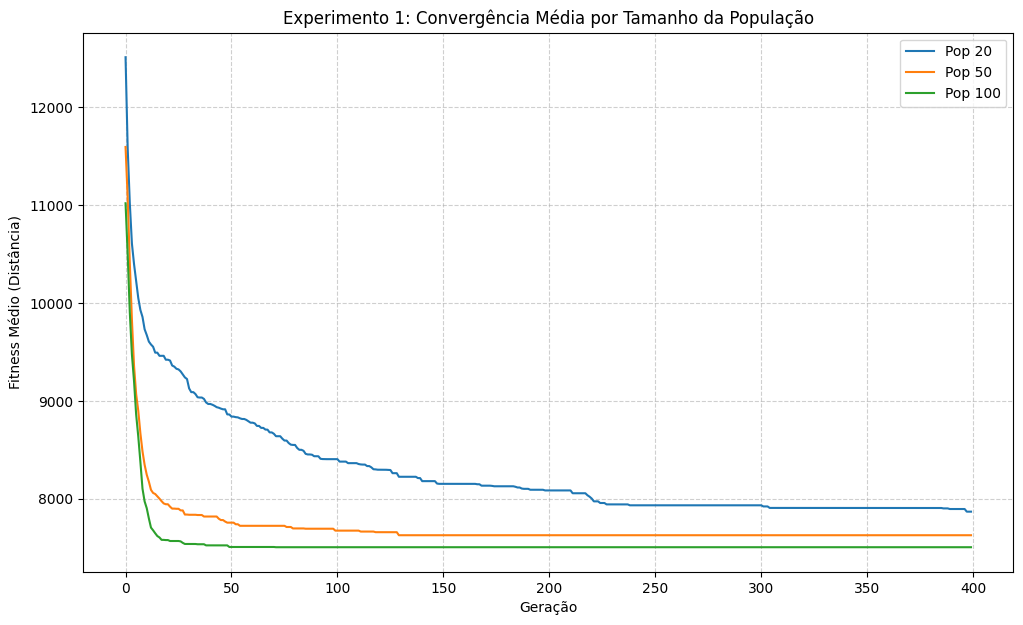

/tmp/ipython-input-929265895.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True,


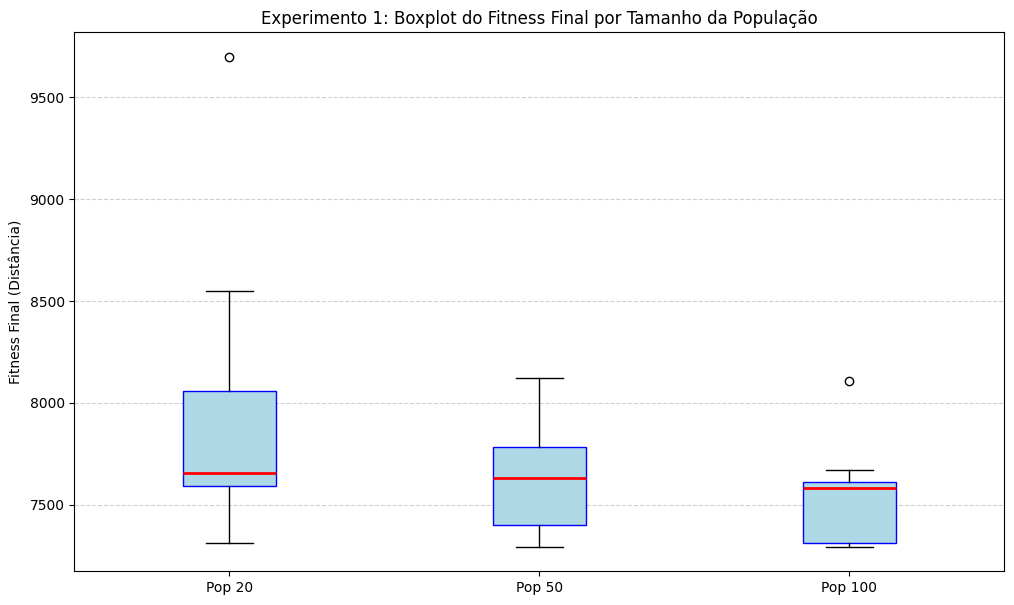

In [8]:
# Gráfico de Linha Convergência
plotar_convergencia_comparativa(
    historicos_exp1,
    "Experimento 1: Convergência Média por Tamanho da População"
)

# Boxplot Qualidade Final
plotar_boxplot_comparativo(
    resultados_exp1,
    "Experimento 1: Boxplot do Fitness Final por Tamanho da População"
)

In [9]:
PARAM_POP_PADRAO = 50 #valor da Atividade 6 como padrão

CONFIGS_MUTACAO = [0.01, 0.05, 0.10, 0.20]

resultados_exp2 = {f"Mut {m*100}%": [] for m in CONFIGS_MUTACAO}
historicos_exp2 = {f"Mut {m*100}%": [] for m in CONFIGS_MUTACAO}

print("\nExperimento 2: Taxa de Mutação")

for tx_mutacao in CONFIGS_MUTACAO:
    label = f"Mut {tx_mutacao*100}%"
    print(f"\nTestando Configuração: {label} (30 execuções)")

    for i in range(NUM_EXECUCOES):

        fitness, _, hist_fit, _ = run_ga(
            pop_size=PARAM_POP_PADRAO,
            geracoes=PARAM_GERACOES,
            tx_crossover=PARAM_TX_CROSSOVER,
            tx_mutacao=tx_mutacao,
            tamanho_torneio=PARAM_TORNEIO,
            elitismo_size=PARAM_ELITISMO_SIZE,
            track_diversity=False
        )
        resultados_exp2[label].append(fitness)
        historicos_exp2[label].append(hist_fit)

        if (i + 1) % 10 == 0:
            print(f"  ... {i+1}/{NUM_EXECUCOES} concluídas")

print("\nResultados Experimento 2")
for tx_mutacao in CONFIGS_MUTACAO:
    label = f"Mut {tx_mutacao*100}%"
    media_fitness = np.mean(resultados_exp2[label])
    print(f"[{label}] Fitness Médio: {media_fitness:.2f}")


Experimento 2: Taxa de Mutação

Testando Configuração: Mut 1.0% (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Mut 5.0% (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Mut 10.0% (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Mut 20.0% (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Resultados Experimento 2
[Mut 1.0%] Fitness Médio: 7653.07
[Mut 5.0%] Fitness Médio: 7757.43
[Mut 10.0%] Fitness Médio: 7560.90
[Mut 20.0%] Fitness Médio: 7556.90


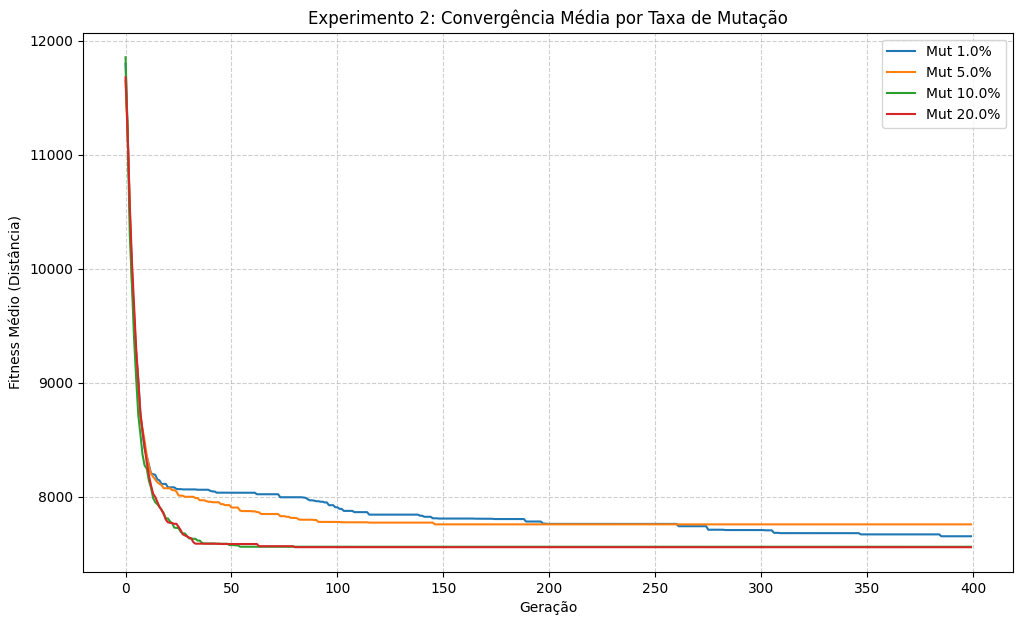

/tmp/ipython-input-929265895.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True,


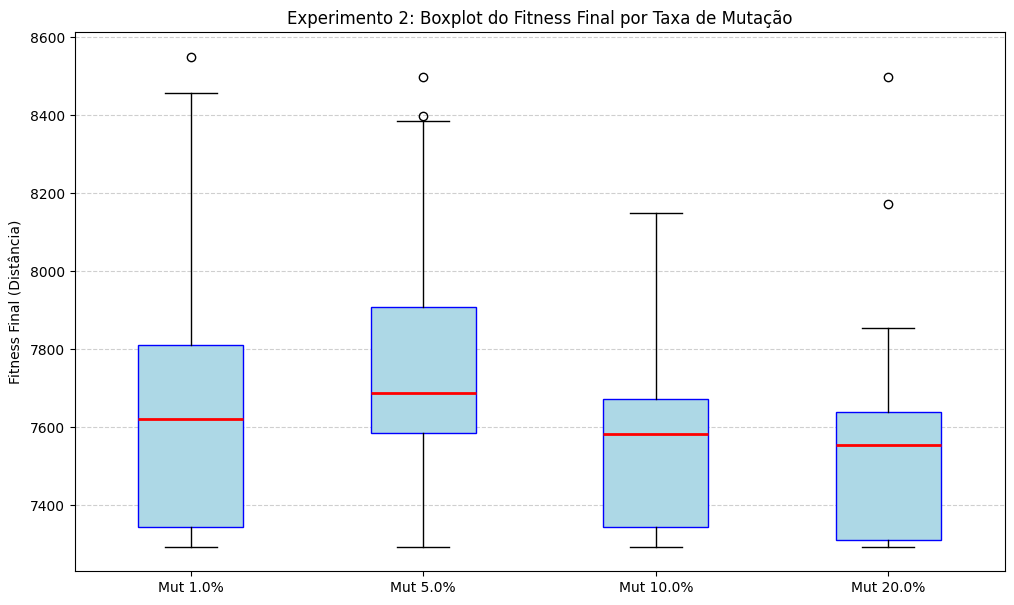

In [10]:
# Gráfico de Linha Convergência
plotar_convergencia_comparativa(
    historicos_exp2,
    "Experimento 2: Convergência Média por Taxa de Mutação"
)

# Boxplot Qualidade Final
plotar_boxplot_comparativo(
    resultados_exp2,
    "Experimento 2: Boxplot do Fitness Final por Taxa de Mutação"
)

In [11]:
CONFIGS_TORNEIO = [2, 3, 5, 7]

resultados_exp3 = {f"Torneio {t}": [] for t in CONFIGS_TORNEIO}

historicos_exp3 = {f"Torneio {t}": [] for t in CONFIGS_TORNEIO}

diversidade_exp3 = {f"Torneio {t}": [] for t in CONFIGS_TORNEIO}

print("\nExperimento 3: Tamanho do Torneio")

for tamanho_torneio in CONFIGS_TORNEIO:
    label = f"Torneio {tamanho_torneio}"
    print(f"\nTestando Configuração: {label} (30 execuções)")

    for i in range(NUM_EXECUCOES):

        fitness, _, hist_fit, hist_div = run_ga(
            pop_size=PARAM_POP_PADRAO,
            geracoes=PARAM_GERACOES,
            tx_crossover=PARAM_TX_CROSSOVER,
            tx_mutacao=PARAM_TX_MUTACAO,
            tamanho_torneio=tamanho_torneio,
            elitismo_size=PARAM_ELITISMO_SIZE,
            track_diversity=True
        )
        resultados_exp3[label].append(fitness)
        historicos_exp3[label].append(hist_fit)
        diversidade_exp3[label].append(hist_div)

        if (i + 1) % 10 == 0:
            print(f"  ... {i+1}/{NUM_EXECUCOES} concluídas")

print("\nResultados Experimento 3")
for tamanho_torneio in CONFIGS_TORNEIO:
    label = f"Torneio {tamanho_torneio}"
    media_fitness = np.mean(resultados_exp3[label])
    media_diversidade_final = np.mean([hist[-1] for hist in diversidade_exp3[label]])
    print(f"[{label}] Fitness Médio: {media_fitness:.2f} | Diversidade Final Média: {media_diversidade_final:.1f} indivíduos")


Experimento 3: Tamanho do Torneio

Testando Configuração: Torneio 2 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Torneio 3 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Torneio 5 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Torneio 7 (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Resultados Experimento 3
[Torneio 2] Fitness Médio: 7589.10 | Diversidade Final Média: 2.9 indivíduos
[Torneio 3] Fitness Médio: 7676.47 | Diversidade Final Média: 2.8 indivíduos
[Torneio 5] Fitness Médio: 7594.97 | Diversidade Final Média: 3.6 indivíduos
[Torneio 7] Fitness Médio: 7612.30 | Diversidade Final Média: 3.3 indivíduos


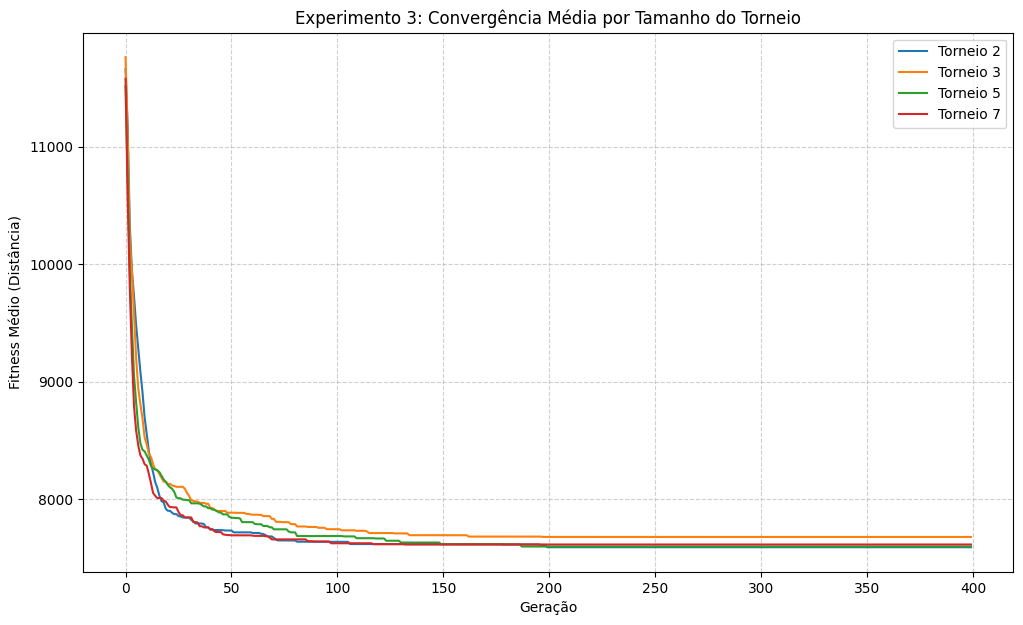

-----------------------------------------------


/tmp/ipython-input-929265895.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True,


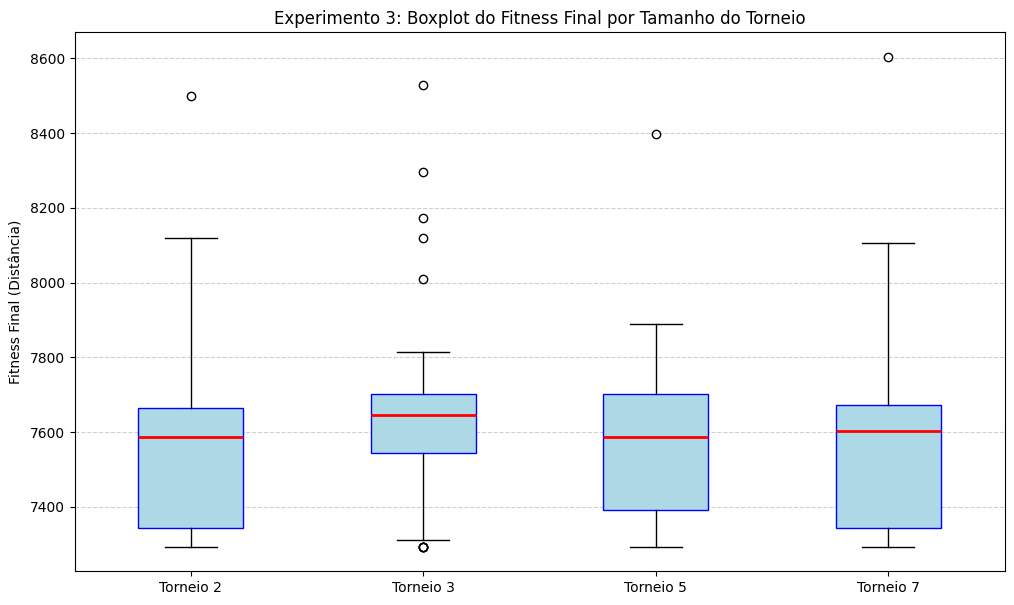

-----------------------------------------------


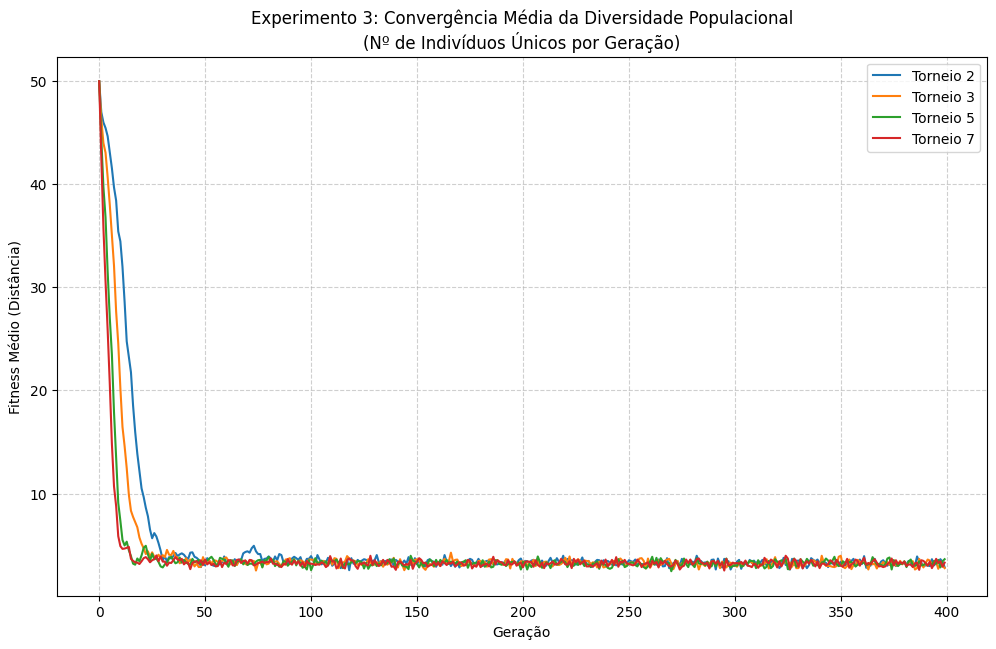

In [15]:
# Gráfico de Linha Convergência de Fitness
plotar_convergencia_comparativa(
    historicos_exp3,
    "Experimento 3: Convergência Média por Tamanho do Torneio"
)
print("-----------------------------------------------")
# Boxplot Qualidade Final
plotar_boxplot_comparativo(
    resultados_exp3,
    "Experimento 3: Boxplot do Fitness Final por Tamanho do Torneio"
)
print("-----------------------------------------------")
# Gráfico de Linha Convergência de Diversidade
plotar_convergencia_comparativa(
    diversidade_exp3,
    "Experimento 3: Convergência Média da Diversidade Populacional\n(Nº de Indivíduos Únicos por Geração)"
)

In [13]:
CONFIGS_ELITISMO_PERC = [0.0, 0.01, 0.05, 0.10]

CONFIGS_ELITISMO_SIZE = [math.ceil(PARAM_POP_PADRAO * p) for p in CONFIGS_ELITISMO_PERC]

labels_exp4 = {size: f"Elite {perc*100}% ({size} ind.)" for size, perc in zip(CONFIGS_ELITISMO_SIZE, CONFIGS_ELITISMO_PERC)}
resultados_exp4 = {labels_exp4[s]: [] for s in CONFIGS_ELITISMO_SIZE}
historicos_exp4 = {labels_exp4[s]: [] for s in CONFIGS_ELITISMO_SIZE}

print("\nExperimento 4: Elitismo")

for elitismo_size in CONFIGS_ELITISMO_SIZE:
    label = labels_exp4[elitismo_size]
    print(f"\nTestando Configuração: {label} (30 execuções)")

    for i in range(NUM_EXECUCOES):

        fitness, _, hist_fit, _ = run_ga(
            pop_size=PARAM_POP_PADRAO,
            geracoes=PARAM_GERACOES,
            tx_crossover=PARAM_TX_CROSSOVER,
            tx_mutacao=PARAM_TX_MUTACAO,
            tamanho_torneio=PARAM_TORNEIO,
            elitismo_size=elitismo_size,
            track_diversity=False
        )
        resultados_exp4[label].append(fitness)
        historicos_exp4[label].append(hist_fit)

        if (i + 1) % 10 == 0:
            print(f"  ... {i+1}/{NUM_EXECUCOES} concluídas")

print("\nResultados Experimento 4")
for elitismo_size in CONFIGS_ELITISMO_SIZE:
    label = labels_exp4[elitismo_size]
    media_fitness = np.mean(resultados_exp4[label])
    print(f"[{label}] Fitness Médio: {media_fitness:.2f}")


Experimento 4: Elitismo

Testando Configuração: Elite 0.0% (0 ind.) (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Elite 1.0% (1 ind.) (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Elite 5.0% (3 ind.) (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Testando Configuração: Elite 10.0% (5 ind.) (30 execuções)
  ... 10/30 concluídas
  ... 20/30 concluídas
  ... 30/30 concluídas

Resultados Experimento 4
[Elite 0.0% (0 ind.)] Fitness Médio: 7648.47
[Elite 1.0% (1 ind.)] Fitness Médio: 7661.13
[Elite 5.0% (3 ind.)] Fitness Médio: 7582.50
[Elite 10.0% (5 ind.)] Fitness Médio: 7657.20


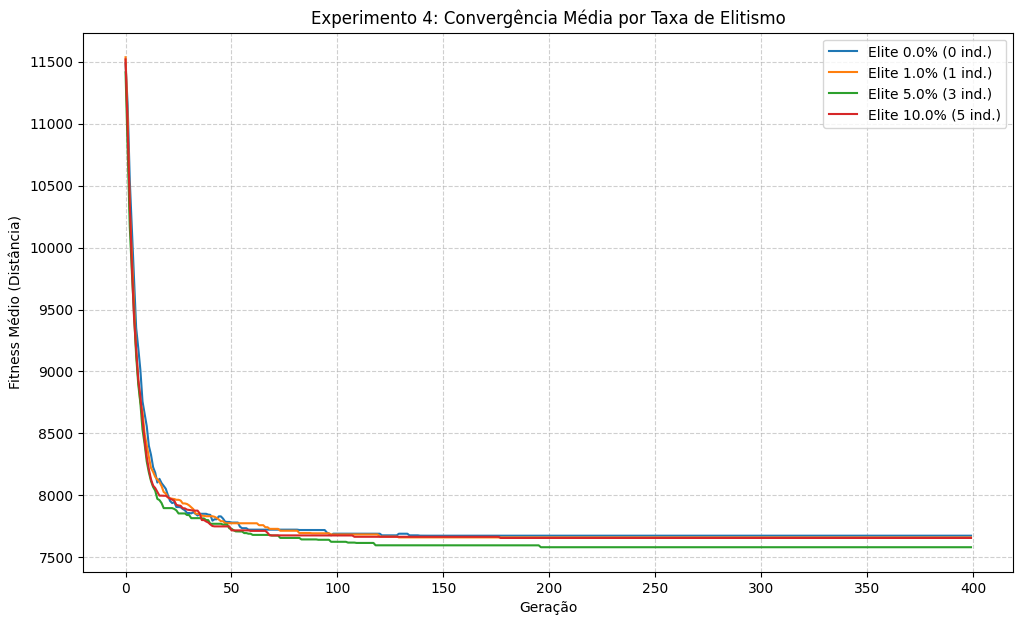

/tmp/ipython-input-929265895.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True,


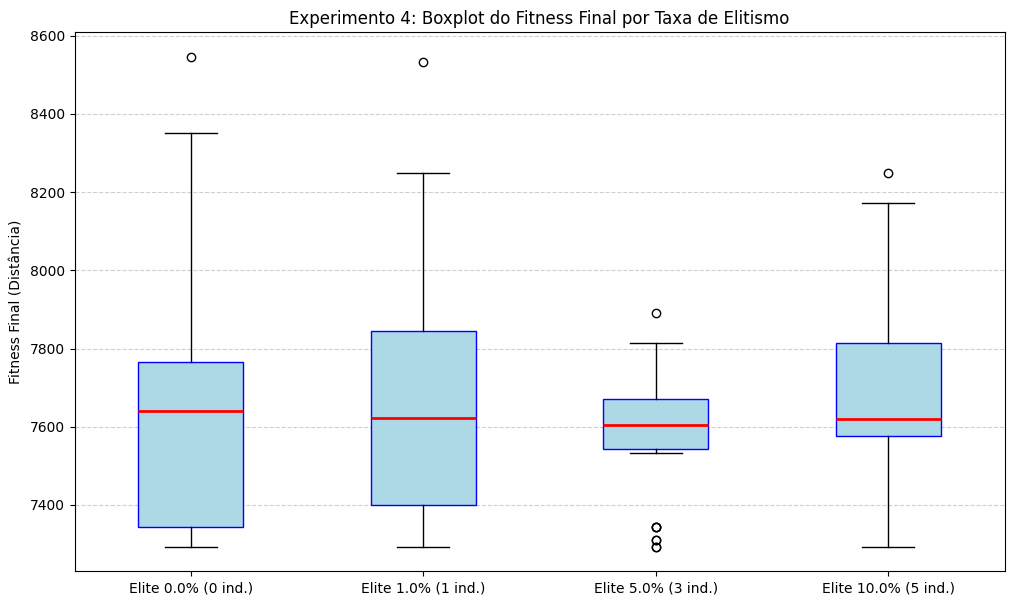


--- Todos os experimentos foram concluídos! ---


In [14]:
# Gráfico de Linha Convergência
plotar_convergencia_comparativa(
    historicos_exp4,
    "Experimento 4: Convergência Média por Taxa de Elitismo"
)

# Boxplot Qualidade Final
plotar_boxplot_comparativo(
    resultados_exp4,
    "Experimento 4: Boxplot do Fitness Final por Taxa de Elitismo"
)
